## ANOVA test

The t-test is used to compare means of two different groups. But if we want to compare more than two groups at the same time, the ANOVA test comes into the play.

We could carry out a seperate t-test for each pair of groups, but you need to conduct many tests and there are chances of increase in false positives.

For instance, ANOVA test can be used to find if spending ammont differes based on the race. (We can compare it to each group).

### One-Way ANOVA

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [7]:
np.random.seed(12)

races = ["asian", "black", "hispanic", "other", "white"]

# Generate random data 
customer_race = np.random.choice(a = races,
                              p = [0.05, 0.15, 0.25, 0.05, 0.5],
                              size = 1000)

customer_spending = stats.poisson.rvs(loc = 160,
                              mu = 180, 
                              size = 1000)

# Group age data by race 
customer_frame = pd.DataFrame({"race" : customer_race, "spending" : customer_spending})
groups = customer_frame.groupby("race").groups

# Extract individual groups 
asian = customer_spending[groups["asian"]]
black = customer_spending[groups["black"]]
hispanic = customer_spending[groups["hispanic"]]
other = customer_spending[groups["other"]]
white = customer_spending[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.2700849903272182, pvalue=0.27993887862129274)

The test output yields an F-statisitic of 1.774 and p-value of 0.1317, indicating that there is no significant difference between the means of each group.

In [8]:
# Another way of ANOVA test using statsmodels library

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('spending ~ race',
            data = customer_frame).fit()

anova_result = sm.stats.anova_lm(model, typ = 2)
print(anova_result)

                 sum_sq     df         F    PR(>F)
race         864.825396    4.0  1.270085  0.279939
Residual  169378.678604  995.0       NaN       NaN


The f-statistic and p-value is same as stats.f_oneway method. Now, we are conducting a second ANOVA where the group mean differ.

In [11]:
np.random.seed(12)

#Generate random data
# Generate random data 
customer_race = np.random.choice(a = races,
                              p = [0.05, 0.15, 0.25, 0.05, 0.5],
                              size = 1000)

# Use a different distribution for white ages
asian_spending = stats.poisson.rvs(loc = 160, 
                               mu = 150,
                               size = 1000)

customer_spending = stats.poisson.rvs(loc = 160,
                               mu = 180,
                               size = 1000)

customer_spending = np.where(customer_race == "asian", asian_spending, customer_spending)

# Group age data by race
customer_frame = pd.DataFrame({"race": customer_race, "spending" : customer_spending})
groups = customer_frame.groupby("race").groups

#Extract individual groups
asian = customer_spending[groups["asian"]]
black = customer_spending[groups["black"]]
hispanic = customer_spending[groups["hispanic"]]
other = customer_spending[groups["other"]]
white = customer_spending[groups["white"]]

# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=42.68216981995261, pvalue=4.499433715390965e-33)

The above f-statistic is large and p-value is extremely small. Hence, we can conclude that there is a difference between the mean groups.

In [13]:
# Alternative  method using another ANOVA library
model = ols('spending ~ race',
            data = customer_frame).fit()

anova_result = sm.stats.anova_lm(model, typ = 2)
print(anova_result)

                 sum_sq     df         F        PR(>F)
race       33802.252344    4.0  42.68217  4.499434e-33
Residual  196998.191656  995.0       NaN           NaN


Since, this is an example and we know that the value which has different mean is asian. But, in real testing data you may not know which groups differ which brings positive ANOVA result. So, we use "post-hoc test".

One post-hoc test is to perform a seperate t-test for each pair of groups by using stats.ttest.ind() 

In [14]:
# Get all race pairs
race_pairs = []

for race1 in range(4):
    for race2 in range(race1 + 1, 5) :
        race_pairs.append((races[race1], races[race2]))

# Conduct t-test on each pair
for race1, race2 in race_pairs:
    print(race1, race2)
    print(stats.ttest_ind(customer_spending[groups[race1]],
                          customer_spending[groups[race2]]))

asian black
TtestResult(statistic=-12.155951131462295, pvalue=1.7065970870516051e-25, df=189.0)
asian hispanic
TtestResult(statistic=-11.969897178669905, pvalue=4.8680099682297216e-27, df=286.0)
asian other
TtestResult(statistic=-8.776344896014326, pvalue=8.565594259163764e-14, df=92.0)
asian white
TtestResult(statistic=-12.707737339934468, pvalue=1.143911231772521e-32, df=557.0)
black hispanic
TtestResult(statistic=-0.44794819722952234, pvalue=0.6544399505994691, df=389.0)
black other
TtestResult(statistic=0.5477710313964791, pvalue=0.5844755841981998, df=195.0)
black white
TtestResult(statistic=0.5162154285108982, pvalue=0.6058768562581311, df=660.0)
hispanic other
TtestResult(statistic=0.8185528593782156, pvalue=0.41370907572649684, df=292.0)
hispanic white
TtestResult(statistic=1.2042935413663347, pvalue=0.2288525440477409, df=757.0)
other white
TtestResult(statistic=-0.2705156569844665, pvalue=0.7868627120173518, df=563.0)


The p-value for pairwise t-test for asian customers are different from other groups, since the p-value for each t-test involves the asian group is below 0.05. Using unadjusted t-tests can overestimate significance. 

The simple way of correction is dividing the significance level by the number of comparions and it known as Bonferroni correction. 

For instance, we compared 10 different races. So, the p-value of 0.05 will be 0.05/10 = 0.005 or less. 

The Bonferroni correction is a conservative approach to account for multiple comparisons problem that may enc up rejecting results that are actually significant. Another common post-hoc test is Turkey's test.

The Turkey's test using the pairwise_turkeyhsd() function  in the statsmodels.stats.multicomp library

group1,group2,meandiff,p-adj,lower,upper,reject
asian,black,28.4519,0.0,21.8441,35.0597,True
asian,hispanic,29.1151,0.0,22.8172,35.4131,True
asian,other,27.2355,0.0,19.2871,35.1838,True
asian,white,27.7925,0.0,21.753,33.832,True
black,hispanic,0.6632,0.9914,-3.3516,4.678,False
black,other,-1.2165,0.9845,-7.5117,5.0788,False
black,white,-0.6594,0.9873,-4.2551,2.9364,False
hispanic,other,-1.8797,0.9112,-7.8489,4.0896,False
hispanic,white,-1.3226,0.7459,-4.311,1.6659,False
other,white,0.5571,0.9989,-5.1388,6.253,False


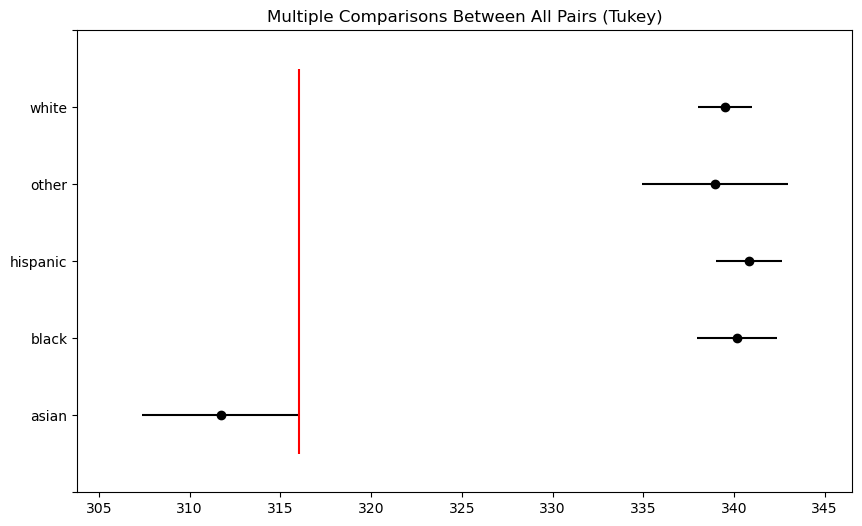

In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

turkey = pairwise_tukeyhsd(endog =  customer_spending,  #Data
                           groups = customer_race, #Groups
                           alpha = 0.05)        #Significance level

turkey.plot_simultaneous() # Plot group confidence intervals
plt.vlines(x = 316, ymin = -0.5, ymax = 4.5, color = "red")

turkey.summary()

The output shows the average difference, a confidence interval as well as which group pair rejects the null hypothesis. For each of the pair including "white" category is differen from others.
No grup overlaps with asian group's confidence interval, hence we conclude that "asian" category has different values.